# Решение задачи:

Будем использовать [датасет](https://www.kaggle.com/datasets/tobiasbueck/multilingual-customer-support-tickets/discussion?sort=hotness), найденный мной на просторах Kaggle. Скачаем его:

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1fxwQ_BaFylGqZ-eay5IuIxSXF-ZruS82' -O something.zip

--2025-06-23 21:09:28--  https://drive.google.com/uc?export=download&id=1fxwQ_BaFylGqZ-eay5IuIxSXF-ZruS82
Resolving drive.google.com (drive.google.com)... 74.125.26.138, 74.125.26.139, 74.125.26.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1fxwQ_BaFylGqZ-eay5IuIxSXF-ZruS82&export=download [following]
--2025-06-23 21:09:28--  https://drive.usercontent.google.com/download?id=1fxwQ_BaFylGqZ-eay5IuIxSXF-ZruS82&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16861699 (16M) [application/octet-stream]
Saving to: ‘something.zip’

something.zip       100%[===================>]  16.08M   100MB/s   

Разархивируем датасета во временную папку 'dataset'

In [ ]:
!unzip -qo "something.zip" -d ./dataset

Установим и импортируем необъодимые библиотеки. Для работы с autokeras нам приходится обновлять более старую версию autokeras, а также устанавливать более старые версии `tensorflow` и `keras-nlp`, так как при установке последней версии `autokeras` возникают ошибки в процессе обучения:

In [ ]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1

Проверим, что подтянулись правильные зависимости и установим оставшиеся библиотеки, необходимые для решение задачи:

In [ ]:
import tensorflow as tf
tf.__version__

'2.15.1'

In [ ]:
import keras_nlp as nlp
nlp.__version__

'0.5.1'

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import autokeras as ak
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

Загружаем данные в DataFrame и изучим их:

In [ ]:
df_main = pd.read_csv("/content/dataset/aa_dataset-tickets-multi-lang-5-2-50-version.csv")
df_main = df_main.drop_duplicates().dropna()
df_main.head()

,subject,body,answer,type,queue,priority,language,version,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
99,Issue Report,"Dear Customer Support Team,\n\nI am submitting...",Thank you for bringing the service issue to ou...,Incident,Technical Support,medium,en,51,Disruption,Outage,Performance,Cloud,SaaS,Service,Workflow,Tech Support
135,Problem with Printer Not Printing Files,"Dear Support Team,\n\nI am reaching out to req...","Thank you for contacting us, <name>. To assist...",Problem,Customer Service,low,en,51,Printer,Hardware,Issue,Support,Printer,Document,Connection,Ink
175,Dringliche Mitteilung: Umfangreiche Serviceunt...,"Sehr geehrtes Support-Team,\n\nich möchte eine...",Vielen Dank für die dringende Mitteilung. Um r...,Incident,Technical Support,high,de,51,Outage,Disruption,Hardware,Software,Service,System,Recovery,Maintenance
195,Ausfall der Cloud-basierten Plattform,"Sehr geehrtes Support-Team,\n\nich möchte eine...","Vielen Dank, dass Sie uns wegen des jüngsten A...",Problem,Technical Support,high,de,51,Outage,Disruption,Performance,Service,Cloud,Stability,Availability,Tech Support
209,Analytics System Outage,"Sehr geehrter Kundendienst,\n\nWir erfahren mo...","<name>,\n\nvielen Dank, dass Sie das Problem m...",Incident,Technical Support,high,de,51,Outage,Disruption,Network,Performance,Server,Data Pipeline,Real-time Analytics,IT


Целевым признаком будет `type`. Также необходимо обработать датасет перед дальнейшим использованием, убрав дубликаты, нулевые значения и ненужные признаки. Выполним фильтр данных, где в обучении модели будут участвовать только записи на английском языке:

In [ ]:
df_main = df_main.drop_duplicates().dropna() #очистка данных
df_main.rename(columns={"type": "ticket_type"}, inplace=True)
df_main = df_main[df_main['language'] == 'en']

Создадим выборки в следующих пропорциях:
* **обучающая** - 70%
* **проверочная** - 15%
* **тестовая** - 15%

`(X_tmp, y_tmp)` - это временная выборка, которую мы делим пополам на проверочную и тестовую.

In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(
    np.array(df_main.body),
    np.array(df_main.ticket_type),
    test_size=0.3,
    stratify=df_main.ticket_type, #стратификация для сохранения баланса
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp,
    test_size=0.5,
    stratify=y_tmp
)

Вычисляем веса классов для балансировки классов.

`compute_class_weight` вычисляет веса классов так, чтобы компенсировать дисбаланс в данных

In [ ]:
#вычисление весов классов для балансировки
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights)) #преобразует массив весов в словарь, где ключи - индексы классов
print("Веса классов:", class_weights)

Веса классов: {0: 3.025, 1: 0.5707547169811321, 2: 1.5921052631578947, 3: 0.7756410256410257}


Посмотрим на форму обучающей выборки и пример первого заголовка в выборке:

In [ ]:
print('Форма входных данных: ', X_train.shape)
print('Форма выходных меток: ', y_train.shape)
print('Пример заголовка: ', X_train[0])

Форма входных данных:  (121,)
Форма выходных меток:  (121,)
Пример заголовка:  Dear Customer Support, I am reaching out to ask about best practices for safeguarding medical data using Ansible within hospital infrastructure. Could you please provide guidance on how to ensure the confidentiality, integrity, and availability of sensitive patient information? I would also appreciate any recommendations or resources you could share on this topic. Thank you for your time and assistance.


Для экономии ОЗУ удаляем уже ненужные данные, после чего python запускает сборщик "мусора" для очистки памяти:

In [ ]:
del df_main, X_tmp, y_tmp

Далее необходимо создать одну из возможных моделей AutoKeras. Так как у нас задача классификации текстов, то мы создаем модель TextClassificator.

In [ ]:
clf = ak.TextClassifier(
    overwrite=True,
    max_trials=2,
    objective='val_accuracy',
    seed=42,
)
result_training = clf.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
)

Trial 2 Complete [00h 00m 14s]
val_accuracy: 0.7692307829856873

Best val_accuracy So Far: 0.8461538553237915
Total elapsed time: 00h 01m 00s
Epoch 1/30
4/4 [==============================] - 2s 268ms/step - loss: 1.3963 - accuracy: 0.2314 - val_loss: 1.3589 - val_accuracy: 0.3462
Epoch 2/30
4/4 [==============================] - 1s 197ms/step - loss: 1.3756 - accuracy: 0.4132 - val_loss: 1.3614 - val_accuracy: 0.3846
Epoch 3/30
4/4 [==============================] - 1s 211ms/step - loss: 1.3526 - accuracy: 0.4793 - val_loss: 1.3627 - val_accuracy: 0.6154
Epoch 4/30
4/4 [==============================] - 1s 209ms/step - loss: 1.3655 - accuracy: 0.4298 - val_loss: 1.3596 - val_accuracy: 0.5769
Epoch 5/30
4/4 [==============================] - 1s 203ms/step - loss: 1.3449 - accuracy: 0.4711 - val_loss: 1.3546 - val_accuracy: 0.5385
Epoch 6/30
4/4 [==============================] - 1s 195ms/step - loss: 1.3293 - accuracy: 0.5041 - val_loss: 1.3451 - val_accuracy: 0.5385
Epoch 7/30
4/4 [==

Последовательно экспортируем лучшую модель и по ней выводим отчет:

In [ ]:
clf.export_model().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLas  (None, 1)                 0         
 tDim)                                                           
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176 

На основе лучшей модели выполним предсказание:

In [ ]:
#предсказание и оценка
predicted_y = clf.predict(X_test)
test_results = clf.evaluate(X_test, y_test)
print("Точность на тестовых данных:", test_results[1])

1/1 [==============================] - 0s 279ms/step - loss: 0.3124 - accuracy: 0.8889
Точность на тестовых данных: 0.8888888955116272


Создадим функцию по созданию 2-ух графиков, а именно: Обучающая и проверочная выборка для *accurary* и для *loss*.

In [ ]:
def plot_graphs(history, key):
    sns.set_style('darkgrid')
    palette = sns.color_palette('Set1')
    plt.figure(figsize=(12,6))
    #отображаем график выбранного параметра
    plt.plot(history.history[key],   #данные для построения графика
             marker='o',             #использовать маркер для точек на графике
             color=palette[2],       #использовать цвет третий в палитре (нумерация с 0)
             linewidth=2.5,          #ширина линии
             label=key)              #подпись легенды

    #график для проверочной выборки
    if 'val_'+key in history.history:
        plt.plot(history.history['val_'+key], #данные для построения графика
                 marker='o',                  #использовать маркер для точек на графике
                 color=palette[4],            #использовать цвет пятый в палитре
                 linewidth=2.5,               #ширина линии
                 label='val_'+key)            #подпись легенды

    plt.xlabel("Эпоха", fontsize=12) #подпись оси Х, размер шрифта - 12
    plt.ylabel(key, fontsize=12) #подпись оси Y, размер шрифта - 12
    plt.title('Обучающая и проверочная выборки ('+key.title()+')', fontsize=14) #подпись заголовка графика, размер шрифта - 14
    plt.legend(fontsize=12) #отображение легенды, размер шрифта - 12
    plt.grid(True) #задаем сетку на графике
    plt.show() #отрисовываем полотно со всеми графиками

Создадим графики через созданную функцию на предыдущем шаге:

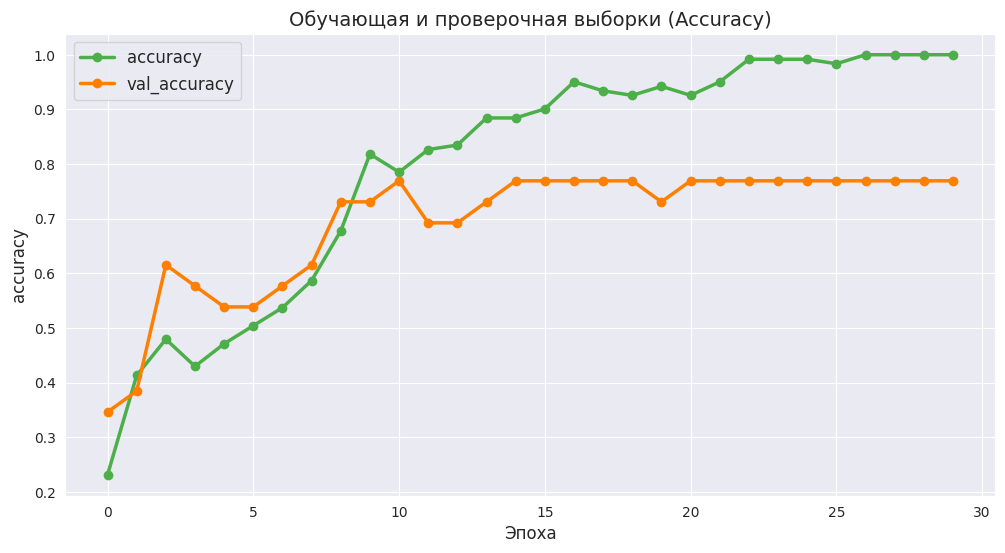

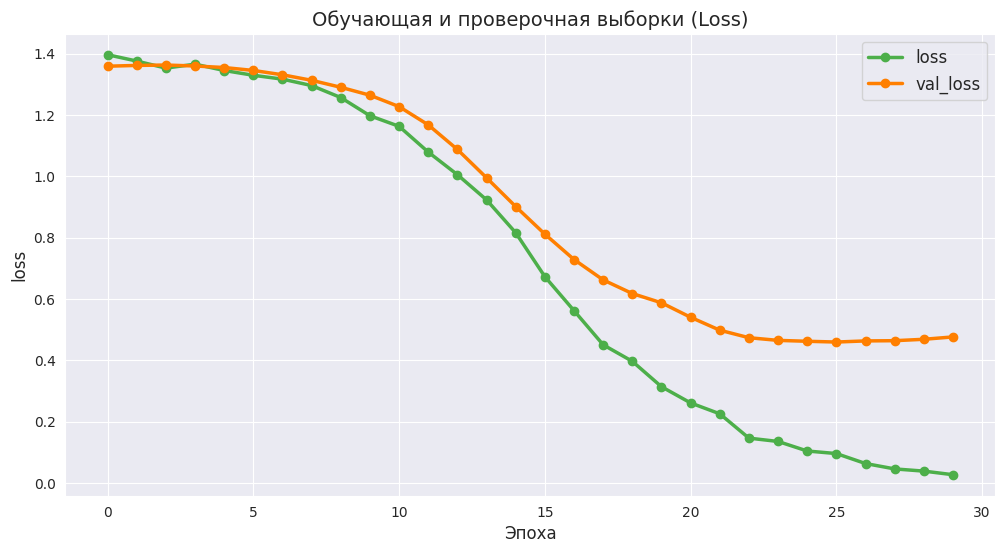

In [ ]:
plot_graphs(result_training, "accuracy")
plot_graphs(result_training, "loss")

Создадим отчет по классификации:

In [ ]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

      Change       1.00      1.00      1.00         2
    Incident       0.85      0.92      0.88        12
     Problem       0.67      0.50      0.57         4
     Request       1.00      1.00      1.00         9

    accuracy                           0.89        27
   macro avg       0.88      0.85      0.86        27
weighted avg       0.88      0.89      0.88        27



Создадим примеры для каждого значения целевого признака и выполним предсказания по ним:

In [ ]:
#примеры для предсказания
examples = {
    "Incident": "The system is down since 10 AM. Users cannot log in.",
    "Request": "How can I reset my password? I forgot it yesterday.",
    "Problem": "Users experience frequent crashes due to memory leak in version 2.1.",
    "Change": "We need to schedule a maintenance window next week to upgrade the database server."
}

for label, text in examples.items(): #классификация каждого примера церез цикл
    result = clf.predict(np.array([text])) #предсказание модели
    predicted_class = result[0][0].decode('utf-8') if isinstance(result[0][0], bytes) else result[0][0] #обработка результата
    print(f"Ожидаемый тип: {label}")
    print(f"Предсказанный тип: {predicted_class}")
    print(f"Результат совпадает? {'Да' if predicted_class == label else 'Нет'}")

1/1 [==============================] - 0s 8ms/step
Ожидаемый тип: Incident
Предсказанный тип: Incident
Результат совпадает? Да
1/1 [==============================] - 0s 11ms/step
Ожидаемый тип: Request
Предсказанный тип: Problem
Результат совпадает? Нет
1/1 [==============================] - 0s 8ms/step
Ожидаемый тип: Problem
Предсказанный тип: Incident
Результат совпадает? Нет


1/1 [==============================] - 0s 24ms/step
Ожидаемый тип: Change
Предсказанный тип: Change
Результат совпадает? Да


Создадим матрицу ошибок:

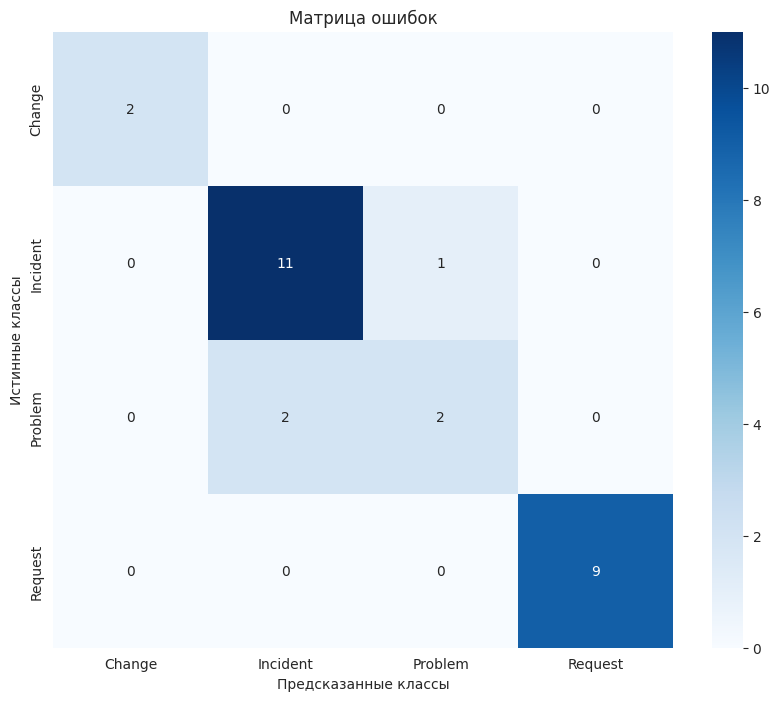

In [ ]:
labels = sorted(list(set(y_test))) #получаем уникальные метки классов
cm = confusion_matrix(y_test, predicted_y, labels=labels) #строим матрицу ошибок
#визуализируем матрицу ошибок
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок')
plt.show()